### call utility functions to get the analysis file

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import dhs_util
from dhs_util import *

os.chdir('/Users/yingli/Development/TopicsInDataScience/')
df = pd.read_csv('dhs_service_records_synthesized_final.csv')
df = dhs_preprocessing(df)
df, service_map = add_service_label(df)
df = add_age_bin(df)

recipient = get_recipient_attribute(df)

* we can get the code documentation 

In [2]:
print(dhs_util.__doc__) # this refreshes at kernel refresh level, i.e., new change in doc string will only be reflected after a restart of the kernel


 
Utility functions for working with Allegheny DHS Synthetic Data
    - @author Ying Li
    - PRECONDITIONS: various parameters
    - POSTCONDITIONS: various
    - PARAMETERS: various




In [3]:
print(dhs_preprocessing.__doc__) 


        Data cleaning rules we follow in this work
        drop the columns that contain NA entirely
        drop the columns that has only one value in its entirety as they have not information. 
        
        because we do not know enough details about how the reocrd data are created/collected
        we will not remove records with age greater than a value, 
        nor will we remove records with seemingly conflict between age and education level
    


In [4]:
df.shape, recipient.shape

((7116134, 12), (533799, 15))

In [5]:
recipient.head()

id  num_service  distinct_service first_date  last_date  num_month  \
0    1           12                 1 2021-01-31 2021-12-31         12   
12   2            1                 1 2021-02-28 2021-02-28          1   
13   3           11                 1 2021-02-28 2021-12-31         11   
24   4            4                 1 2021-03-31 2021-12-31          4   
28   5           12                 1 2021-01-31 2021-12-31         12   

    distinct_month  age    gender                      race  \
0               12   13    1~Male                99~Unknown   
12               1   70  2~Female                   1~White   
13              11   29  2~Female                   1~White   
24               4    4  2~Female                   1~White   
28              12   40    1~Male  2~Black/African American   

                ethnicity                 marital  \
0   2~Not Hispanic/Latinx              99~Unknown   
12  2~Not Hispanic/Latinx               2~Married   
13  2~Not Hispanic/Latinx               2~Married   
24  2~Not Hispanic/Latinx  1~Single-Never Married   
28  2~Not Hispanic/Latinx               2~Married   

                                education serv age_bin  
0   GED~High School Diploma/GED Completed  S12   10-19  
12                             99~Unknown  S12   70-79  
13          9-12~High School (grade 9-12)  S12   20-29  
24          9-12~High School (grade 9-12)  S12     0-9  
28                 UNDERGRAD~Some College  S12   40-49

In [6]:
service_map

{'Children_Attending_Early_Childhood_Programs_Managed_by_DHS': 'S01',
 'Children_in_Care': 'S02',
 'Children_Receiving_Child_Welfare_Services': 'S03',
 'Children_Receiving_DHS_Funded_Out_of_School_Programs': 'S04',
 'Children_Receiving_Early_Intervention_Services': 'S05',
 'Families_Receiving_Child_Welfare_Services': 'S06',
 'Homeless_Population': 'S07',
 'Homicides': 'S08',
 'Individuals_Receiving_DHS_Services': 'S09',
 'Individuals_Receiving_Family_Strengthening_Programs': 'S10',
 'Individuals_Receiving_Homelessness_and_Housing_Services': 'S11',
 'Individuals_Receiving_Income_Supports': 'S12',
 'Individuals_Receiving_Intellectual_Disability_Services': 'S13',
 'Individuals_Receiving_Mental_Health_Services': 'S14',
 'Individuals_Receiving_Substance_Use_Disorder_Services': 'S15',
 'Involuntary_Commitments': 'S16',
 'Jail_Population': 'S17',
 'Mental_Health_Crises': 'S18',
 'Older_Adults_Receiving_Services': 'S19',
 'Overdoses': 'S20',
 'Parents_Receiving_Child_Welfare_Services': 'S21',


In [7]:
def get_service_attribute(df):
    service = df.groupby(['serv']).agg(
        num_recipient = ('id', 'count'),
        distinct_recipient = ('id', 'nunique'), 
        num_month = ('month', 'count'), 
        distinct_month = ('month', 'nunique')
    ).reset_index()
    return service

In [8]:
service = get_service_attribute(df)

In [9]:
service

serv  num_recipient  distinct_recipient  num_month  distinct_month
0   S01           2302                 349       2302              12
1   S03          50373                7306      50373              12
2   S04           4606                1198       4606              12
3   S05          45923                6752      45923              12
4   S02          18442                2237      18442              12
5   S06          23473                3118      23473              12
6   S07          13950                3415      13950              12
7   S08            172                 172        172              12
8   S09         626722               82122     626722              12
9   S10          28110                2986      28110              12
10  S11         148968               21823     148968              12
11  S12        5450993              502530    5450993              12
12  S13          74145                6360      74145              12
13  S14         324241               55263     324241              12
14  S15          74737               12812      74737              12
15  S16           7061                5010       7061              12
16  S17          26987                6922      26987              12
17  S18           7245                7245       7245              12
18  S19         131153               16759     131153              12
19  S20           1319                1319       1319              12
20  S21          54035                7078      54035              12
21  S22           1177                1177       1177              12

In [10]:
service.num_recipient/service.distinct_month

0        191.833333
1       4197.750000
2        383.833333
3       3826.916667
4       1536.833333
5       1956.083333
6       1162.500000
7         14.333333
8      52226.833333
9       2342.500000
10     12414.000000
11    454249.416667
12      6178.750000
13     27020.083333
14      6228.083333
15       588.416667
16      2248.916667
17       603.750000
18     10929.416667
19       109.916667
20      4502.916667
21        98.083333
dtype: float64

### Retention cohorts 
* group recipients by their first usage of any services, the first month of receiving services
* this grouping would create a set of cohorts, each cohort correspond to the month where all member of the cohort started using the services for the first time (in this dataset)
* This would be assuming January is the beginning of history
* we already have the first month in the dataframe recipient
* we want to attach this first month back to the overall service usage table (the full transaction dataset) so that we can compute the elapsed time of each usage of the service to the first months 
* then aggregate over the first month (the cohort) and the elaped months, this will yield number of recipients who are still receiving services at the nth month (the elapsed month)

* we will use merge, and we will only need the date columns

In [11]:
df_retention = pd.merge(df, recipient[['id','first_date']], on = 'id', how = 'left')
df_retention['elapsed'] = df_retention['date'].dt.month - df_retention['first_date'].dt.month
df_retention.head(30)

id       date                                            service  age  \
0   1626 2021-01-31  Children_Attending_Early_Childhood_Programs_Ma...    5   
1   1626 2021-02-28  Children_Attending_Early_Childhood_Programs_Ma...    5   
2   1626 2021-03-31  Children_Attending_Early_Childhood_Programs_Ma...    5   
3   1626 2021-04-30  Children_Attending_Early_Childhood_Programs_Ma...    5   
4   1626 2021-05-31  Children_Attending_Early_Childhood_Programs_Ma...    5   
5   1626 2021-06-30  Children_Attending_Early_Childhood_Programs_Ma...    5   
6   3775 2021-01-31  Children_Attending_Early_Childhood_Programs_Ma...    5   
7   3775 2021-02-28  Children_Attending_Early_Childhood_Programs_Ma...    5   
8   3775 2021-03-31  Children_Attending_Early_Childhood_Programs_Ma...    5   
9   3775 2021-04-30  Children_Attending_Early_Childhood_Programs_Ma...    5   
10  3775 2021-05-31  Children_Attending_Early_Childhood_Programs_Ma...    5   
11  3775 2021-06-30  Children_Attending_Early_Childhood_Programs_Ma...    5   
12  3775 2021-07-31  Children_Attending_Early_Childhood_Programs_Ma...    5   
13  3775 2021-08-31  Children_Attending_Early_Childhood_Programs_Ma...    5   
14  3775 2021-09-30  Children_Attending_Early_Childhood_Programs_Ma...    5   
15  3775 2021-10-31  Children_Attending_Early_Childhood_Programs_Ma...    5   
16  3775 2021-11-30  Children_Attending_Early_Childhood_Programs_Ma...    5   
17  3775 2021-12-31  Children_Attending_Early_Childhood_Programs_Ma...    5   
18  5570 2021-01-31  Children_Attending_Early_Childhood_Programs_Ma...    5   
19  5570 2021-02-28  Children_Attending_Early_Childhood_Programs_Ma...    5   
20  5570 2021-03-31  Children_Attending_Early_Childhood_Programs_Ma...    5   
21  5570 2021-04-30  Children_Attending_Early_Childhood_Programs_Ma...    5   
22  5570 2021-05-31  Children_Attending_Early_Childhood_Programs_Ma...    5   
23  5570 2021-06-30  Children_Attending_Early_Childhood_Programs_Ma...    5   
24  6022 2021-09-30  Children_Attending_Early_Childhood_Programs_Ma...    4   
25  6022 2021-10-31  Children_Attending_Early_Childhood_Programs_Ma...    4   
26  6022 2021-11-30  Children_Attending_Early_Childhood_Programs_Ma...    4   
27  6022 2021-12-31  Children_Attending_Early_Childhood_Programs_Ma...    4   
28  7912 2021-01-31  Children_Attending_Early_Childhood_Programs_Ma...    4   
29  7912 2021-02-28  Children_Attending_Early_Childhood_Programs_Ma...    4   

      gender                      race              ethnicity  \
0     1~Male                   1~White             99~Unknown   
1     1~Male                   1~White             99~Unknown   
2     1~Male                   1~White             99~Unknown   
3     1~Male                   1~White             99~Unknown   
4     1~Male                   1~White             99~Unknown   
5     1~Male                   1~White             99~Unknown   
6     1~Male                99~Unknown             99~Unknown   
7     1~Male                99~Unknown             99~Unknown   
8     1~Male                99~Unknown             99~Unknown   
9     1~Male                99~Unknown             99~Unknown   
10    1~Male                99~Unknown             99~Unknown   
11    1~Male                99~Unknown             99~Unknown   
12    1~Male                99~Unknown             99~Unknown   
13    1~Male                99~Unknown             99~Unknown   
14    1~Male                99~Unknown             99~Unknown   
15    1~Male                99~Unknown             99~Unknown   
16    1~Male                99~Unknown             99~Unknown   
17    1~Male                99~Unknown             99~Unknown   
18    1~Male                   1~White  2~Not Hispanic/Latinx   
19    1~Male                   1~White  2~Not Hispanic/Latinx   
20    1~Male                   1~White  2~Not Hispanic/Latinx   
21    1~Male                   1~White  2~Not Hispanic/Latinx   
22    1~Male                   1~White  2~Not Hispanic/Latinx

In [12]:
df_retention_count = df_retention.groupby(["first_date", "elapsed"]).agg(
    num_active = ("id", "nunique"),
    ).reset_index()
df_retention_count = df_retention_count.pivot(index = "first_date", columns="elapsed", values='num_active')


In [13]:
df_retention_count

elapsed           0         1         2         3         4         5   \
first_date                                                               
2021-01-31  457593.0  436881.0  438529.0  439693.0  437510.0  438422.0   
2021-02-28   24326.0   13095.0   13818.0   13204.0   13740.0   14392.0   
2021-03-31   14139.0    7761.0    7485.0    8039.0    8426.0    8719.0   
2021-04-30    7818.0    4204.0    4516.0    4815.0    5048.0    5699.0   
2021-05-31    4679.0    2627.0    2856.0    3091.0    3444.0    3648.0   
2021-06-30    3086.0    1821.0    2003.0    2089.0    2240.0    2342.0   
2021-07-31    2400.0    1435.0    1501.0    1578.0    1668.0    1571.0   
2021-08-31    2829.0    1856.0    1968.0    2095.0    1995.0       NaN   
2021-09-30    1626.0     854.0    1016.0     920.0       NaN       NaN   
2021-10-31    4028.0    3400.0    3300.0       NaN       NaN       NaN   
2021-11-30    5036.0    4536.0       NaN       NaN       NaN       NaN   
2021-12-31    6239.0       NaN       NaN       NaN       NaN       NaN   

elapsed           6         7         8         9         10        11  
first_date                                                              
2021-01-31  439177.0  439569.0  441966.0  441414.0  440636.0  437669.0  
2021-02-28   14829.0   16244.0   16872.0   17155.0   16207.0       NaN  
2021-03-31    9703.0   10537.0   11006.0   10479.0       NaN       NaN  
2021-04-30    6169.0    6377.0    6211.0       NaN       NaN       NaN  
2021-05-31    3826.0    3734.0       NaN       NaN       NaN       NaN  
2021-06-30    2263.0       NaN       NaN       NaN       NaN       NaN  
2021-07-31       NaN       NaN       NaN       NaN       NaN       NaN  
2021-08-31       NaN       NaN       NaN       NaN       NaN       NaN  
2021-09-30       NaN       NaN       NaN       NaN       NaN       NaN  
2021-10-31       NaN       NaN       NaN       NaN       NaN       NaN  
2021-11-30       NaN       NaN       NaN       NaN       NaN       NaN  
2021-12-31       NaN       NaN       NaN       NaN       NaN       NaN

* how can we verify this?

In [14]:
recipient.groupby("first_date").id.nunique()

first_date
2021-01-31    457593
2021-02-28     24326
2021-03-31     14139
2021-04-30      7818
2021-05-31      4679
2021-06-30      3086
2021-07-31      2400
2021-08-31      2829
2021-09-30      1626
2021-10-31      4028
2021-11-30      5036
2021-12-31      6239
Name: id, dtype: int64

### getting retention rate

In [15]:
df_retention_ratio = df_retention_count.reset_index()
df_retention_ratio = df_retention_count.div(df_retention_ratio.iloc[:,1].to_numpy(),axis = 0)
df_retention_ratio

elapsed      0         1         2         3         4         5         6   \
first_date                                                                    
2021-01-31  1.0  0.954737  0.958339  0.960882  0.956112  0.958105  0.959755   
2021-02-28  1.0  0.538313  0.568034  0.542794  0.564828  0.591630  0.609595   
2021-03-31  1.0  0.548907  0.529387  0.568569  0.595940  0.616663  0.686258   
2021-04-30  1.0  0.537733  0.577641  0.615886  0.645689  0.728959  0.789076   
2021-05-31  1.0  0.561445  0.610387  0.660611  0.736055  0.779654  0.817696   
2021-06-30  1.0  0.590084  0.649060  0.676928  0.725859  0.758911  0.733312   
2021-07-31  1.0  0.597917  0.625417  0.657500  0.695000  0.654583       NaN   
2021-08-31  1.0  0.656062  0.695652  0.740544  0.705196       NaN       NaN   
2021-09-30  1.0  0.525215  0.624846  0.565806       NaN       NaN       NaN   
2021-10-31  1.0  0.844091  0.819265       NaN       NaN       NaN       NaN   
2021-11-30  1.0  0.900715       NaN       NaN       NaN       NaN       NaN   
2021-12-31  1.0       NaN       NaN       NaN       NaN       NaN       NaN   

elapsed           7         8         9         10        11  
first_date                                                    
2021-01-31  0.960611  0.965850  0.964643  0.962943  0.956459  
2021-02-28  0.667763  0.693579  0.705213  0.666242       NaN  
2021-03-31  0.745244  0.778414  0.741142       NaN       NaN  
2021-04-30  0.815682  0.794449       NaN       NaN       NaN  
2021-05-31  0.798034       NaN       NaN       NaN       NaN  
2021-06-30       NaN       NaN       NaN       NaN       NaN  
2021-07-31       NaN       NaN       NaN       NaN       NaN  
2021-08-31       NaN       NaN       NaN       NaN       NaN  
2021-09-30       NaN       NaN       NaN       NaN       NaN  
2021-10-31       NaN       NaN       NaN       NaN       NaN  
2021-11-30       NaN       NaN       NaN       NaN       NaN  
2021-12-31       NaN       NaN       NaN       NaN       NaN

* plot in heatmap

<Axes: xlabel='elapsed', ylabel='first_date'>

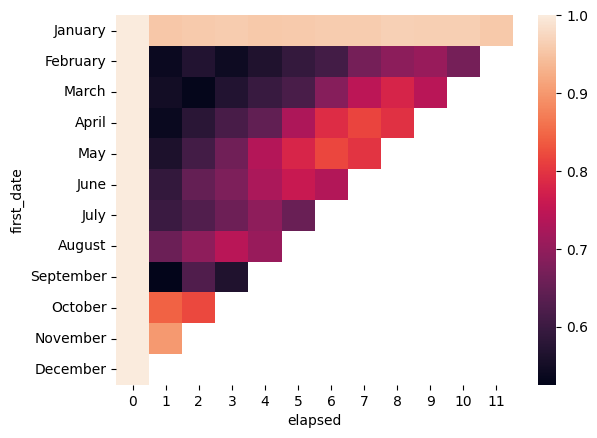

In [16]:
sns.heatmap(df_retention_ratio, annot=False,
            yticklabels=pd.to_datetime(df_retention_ratio.index.values).month_name())

### to compute correlation between usage of services 
* need to create a new dataframe that has row for each recipient and columns for individual services and the value being the times/months the recipent used the services
* we first make teh service usage into a "long table", each row is "id", "service", "number of times used"
* we then can pivot the service column into individual services as columns, each row is for each recipient, and columns as service 1, service 2, service 3 ...
* correlation can then becomputed over the pairwise columns 

In [17]:
df_temp = df.groupby(["id","serv"]).agg(
    num_serv = ('service', 'nunique') # this will be 1 or 0, "service" is categorical 
).reset_index()

In [18]:
df_temp.head(30)

id serv  num_serv
0    1  S01         0
1    1  S03         0
2    1  S04         0
3    1  S05         0
4    1  S02         0
5    1  S06         0
6    1  S07         0
7    1  S08         0
8    1  S09         0
9    1  S10         0
10   1  S11         0
11   1  S12         1
12   1  S13         0
13   1  S14         0
14   1  S15         0
15   1  S16         0
16   1  S17         0
17   1  S18         0
18   1  S19         0
19   1  S20         0
20   1  S21         0
21   1  S22         0
22   2  S01         0
23   2  S03         0
24   2  S04         0
25   2  S05         0
26   2  S02         0
27   2  S06         0
28   2  S07         0
29   2  S08         0

In [19]:
df_serv = df_temp.pivot_table(
    values='num_serv', 
    index=["id"], columns="serv", aggfunc=np.sum
    ).reset_index()

In [55]:
df_serv.head()

serv  id  S01  S03  S04  S05  S02  S06  S07  S08  S09  ...  S13  S14  S15  \
0      1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
1      2    0    0    0    0    0    0    0    0    0  ...    0    0    0   
2      3    0    0    0    0    0    0    0    0    0  ...    0    0    0   
3      4    0    0    0    0    0    0    0    0    0  ...    0    0    0   
4      5    0    0    0    0    0    0    0    0    0  ...    0    0    0   

serv  S16  S17  S18  S19  S20  S21  S22  
0       0    0    0    0    0    0    0  
1       0    0    0    0    0    0    0  
2       0    0    0    0    0    0    0  
3       0    0    0    0    0    0    0  
4       0    0    0    0    0    0    0  

[5 rows x 23 columns]

In [21]:
df_serv[['S09','S12','S14','S19']].describe()

serv             S09            S12            S14            S19
count  533799.000000  533799.000000  533799.000000  533799.000000
mean        0.153844       0.941422       0.103528       0.031396
std         0.360800       0.234834       0.304647       0.174385
min         0.000000       0.000000       0.000000       0.000000
25%         0.000000       1.000000       0.000000       0.000000
50%         0.000000       1.000000       0.000000       0.000000
75%         0.000000       1.000000       0.000000       0.000000
max         1.000000       1.000000       1.000000       1.000000

In [22]:
df_serv.head(30)

serv  id  S01  S03  S04  S05  S02  S06  S07  S08  S09  ...  S13  S14  S15  \
0      1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
1      2    0    0    0    0    0    0    0    0    0  ...    0    0    0   
2      3    0    0    0    0    0    0    0    0    0  ...    0    0    0   
3      4    0    0    0    0    0    0    0    0    0  ...    0    0    0   
4      5    0    0    0    0    0    0    0    0    0  ...    0    0    0   
5      6    0    0    0    0    0    0    0    0    1  ...    0    0    0   
6      7    0    0    0    0    0    0    0    0    0  ...    0    0    0   
7      8    0    0    0    0    0    0    0    0    0  ...    0    0    0   
8      9    0    0    0    0    0    0    0    0    0  ...    0    0    0   
9     10    0    0    0    0    0    0    0    0    0  ...    0    0    0   
10    11    0    0    0    0    0    0    0    0    0  ...    0    0    0   
11    12    0    0    0    0    0    0    0    0    0  ...    0    0    0   
12    13    0    0    0    0    0    0    0    0    0  ...    0    0    0   
13    14    0    0    0    0    0    0    0    0    0  ...    0    0    0   
14    15    0    0    0    0    0    0    0    0    0  ...    0    0    0   
15    16    0    0    0    0    0    0    0    0    0  ...    0    0    0   
16    17    0    0    0    0    0    0    0    0    1  ...    0    1    0   
17    18    0    0    0    0    0    0    0    0    0  ...    0    0    0   
18    19    0    0    0    0    0    0    0    0    0  ...    0    0    0   
19    20    0    1    0    0    0    0    0    0    0  ...    0    0    0   
20    21    0    0    0    0    0    0    0    0    0  ...    0    0    0   
21    22    0    0    0    0    0    0    0    0    0  ...    0    0    0   
22    23    0    0    0    0    0    0    0    0    1  ...    0    1    0   
23    24    0    0    0    0    0    0    0    0    0  ...    0    0    0   
24    25    0    0    0    0    0    0    0    0    0  ...    0    0    0   
25    26    0    0    0    0    0    0    0    0    1  ...    0    1    0   
26    27    0    0    0    0    0    0    0    0    0  ...    0    0    0   
27    28    0    0    0    0    0    0    0    0    0  ...    0    0    0   
28    29    0    0    0    0    0    0    0    0    0  ...    0    0    0   
29    31    0    0    0    0    0    0    0    0    0  ...    0    0    0   

serv  S16  S17  S18  S19  S20  S21  S22  
0       0    0    0    0    0    0    0  
1       0    0    0    0    0    0    0  
2       0    0    0    0    0    0    0  
3       0    0    0    0    0    0    0  
4       0    0    0    0    0    0    0  
5       0    0    0    0    0    0    0  
6       0    0    0    0    0    0    0  
7       0    0    0    0    0    0    0  
8       0    0    0    0    0    0    0  
9       0    0    0    0    0    0    0  
10      0    0    0    0    0    0    0  
11      0    0    0    0    0    0    0  
12      0    0    0    0    0    0    0  
13      0    0    0    0    0    0    0  
14      0    0    0    0    0    0    0  
15      0    0    0    0    0    0    0  
16      0    0    0    0    0    0    0  
17      0    0    0    0    0    0    0  
18      0    0    0    0    0    0    0  
19      0    0    0    0    0    0    0  
20      0    0    0    0    0    0    0  
21      0    0    0    1    0    0    0  
22      0    0    0    0    0    0    0  
23      0    0    0    0    0    0    0  
24      0    0    0    0    0    0    0  
25      0    0    0    0    0    0    0  
26      0    0    0    0    0    0    0  
27      0    0    0    1    0    0    0  
28      0    0    0    0    0    0    0  
29      0    0    0    0    0    0    0  

[30 rows x 23 columns]

In [23]:
df_serv.iloc[:,1:22].sum()

serv
S01       349
S03      7306
S04      1198
S05      6752
S02      2237
S06      3118
S07      3415
S08       172
S09     82122
S10      2986
S11     21823
S12    502530
S13      6360
S14     55263
S15     12812
S16      5010
S17      6922
S18      7245
S19     16759
S20      1319
S21      7078
dtype: int64

In [24]:
df_serv.iloc[:,1:23].corr(method="spearman")

serv       S01       S03       S04       S05       S02       S06       S07  \
serv                                                                         
S01   1.000000  0.030419  0.032860  0.004319  0.018762 -0.001961 -0.000214   
S03   0.030419  1.000000  0.072781  0.081313  0.544207 -0.005433  0.021894   
S04   0.032860  0.072781  1.000000 -0.001826  0.044724 -0.002077  0.003146   
S05   0.004319  0.081313 -0.001826  1.000000  0.106316 -0.007576  0.002482   
S02   0.018762  0.544207  0.044724  0.106316  1.000000 -0.003450  0.014072   
S06  -0.001961 -0.005433 -0.002077 -0.007576 -0.003450  1.000000  0.005566   
S07  -0.000214  0.021894  0.003146  0.002482  0.014072  0.005566  1.000000   
S08  -0.000459 -0.001217  0.003560 -0.001098 -0.001165  0.015061 -0.001441   
S09  -0.007859  0.075569  0.011817 -0.003613  0.068950  0.072723  0.084637   
S10   0.033457  0.111580  0.020329  0.013987  0.067067  0.025894  0.010994   
S11  -0.003430  0.017288 -0.001395 -0.012024  0.010771  0.023281  0.388658   
S12  -0.051668 -0.022042 -0.073472 -0.146728  0.001610 -0.115086 -0.049024   
S13  -0.001458  0.004897 -0.001924 -0.005013 -0.000175 -0.002979 -0.004047   
S14  -0.006286  0.066561  0.006364  0.002695  0.073240  0.029147  0.069682   
S15  -0.004011 -0.014575 -0.006144 -0.017750 -0.008089  0.067487  0.055119   
S16  -0.001730 -0.002604 -0.002564 -0.006845  0.002708  0.008856  0.038246   
S17  -0.002932 -0.012220 -0.005436 -0.012973 -0.007436  0.016421  0.036079   
S18  -0.003000  0.021019 -0.001800 -0.002411  0.023719  0.013742  0.099230   
S19  -0.004605 -0.021208 -0.008539 -0.020378 -0.011679 -0.009289 -0.003398   
S20  -0.001273 -0.004889 -0.000766 -0.004283 -0.003229  0.018467  0.000739   
S21  -0.002965 -0.009568 -0.004460 -0.013121 -0.005492  0.516809  0.016170   
S22  -0.001202 -0.004850 -0.001385 -0.004606 -0.003050 -0.000983 -0.003772   

serv       S08       S09       S10  ...       S13       S14       S15  \
serv                                ...                                 
S01  -0.000459 -0.007859  0.033457  ... -0.001458 -0.006286 -0.004011   
S03  -0.001217  0.075569  0.111580  ...  0.004897  0.066561 -0.014575   
S04   0.003560  0.011817  0.020329  ... -0.001924  0.006364 -0.006144   
S05  -0.001098 -0.003613  0.013987  ... -0.005013  0.002695 -0.017750   
S02  -0.001165  0.068950  0.067067  ... -0.000175  0.073240 -0.008089   
S06   0.015061  0.072723  0.025894  ... -0.002979  0.029147  0.067487   
S07  -0.001441  0.084637  0.010994  ... -0.004047  0.069682  0.055119   
S08   1.000000 -0.001580  0.000053  ... -0.001971 -0.002332 -0.000769   
S09  -0.001580  1.000000  0.077110  ...  0.168234  0.796974  0.284997   
S10   0.000053  0.077110  1.000000  ...  0.001950  0.042368  0.021389   
S11  -0.001071  0.168200  0.026628  ... -0.008372  0.085235  0.081420   
S12  -0.024858 -0.067292 -0.001614  ...  0.009084 -0.042311 -0.000964   
S13  -0.001971  0.168234  0.001950  ...  1.000000  0.100856 -0.001878   
S14  -0.002332  0.796974  0.042368  ...  0.100856  1.000000  0.158765   
S15  -0.000769  0.284997  0.021389  ... -0.001878  0.158765  1.000000   
S16   0.001500  0.227900  0.003901  ...  0.014380  0.285919  0.043001   
S17   0.003478  0.116026  0.004502  ...  0.007559  0.096771  0.163351   
S18   0.000600  0.272582  0.011391  ...  0.022335  0.341985  0.081782   
S19  -0.001437  0.006959 -0.005725  ... -0.006305 -0.021793 -0.008931   
S20   0.009619  0.001891 -0.002215  ... -0.001640 -0.001679  0.016109   
S21   0.010694  0.143173  0.035663  ...  0.001007  0.052213  0.114724   
S22  -0.000844 -0.018273 -0.002990  ... -0.005162 -0.014664 -0.006850   

serv       S16       S17       S18       S19       S20       S21       S22  
serv                                                                        
S01  -0.001730 -0.002932 -0.003000 -0.004605 -0.001273 -0.002965 -0.001202  
S03  -0.002604 -0.012220  0.021019 -0.021208 -0.004889 -0.009568 -0.004850  
S04  -0.002564 -0.005436 -0.001800 -0.008539 -0.000766 -0.004460 -

* double check S14 and S09
* double check S12 and S09

In [25]:
from scipy.stats import pearsonr   
pearsonr(df_serv.S12, df_serv.S09), pearsonr(df_serv.S14, df_serv.S09)[0]

(PearsonRResult(statistic=-0.06729155634901972, pvalue=0.0),
 0.7969739943925933)

<Axes: xlabel='serv', ylabel='serv'>

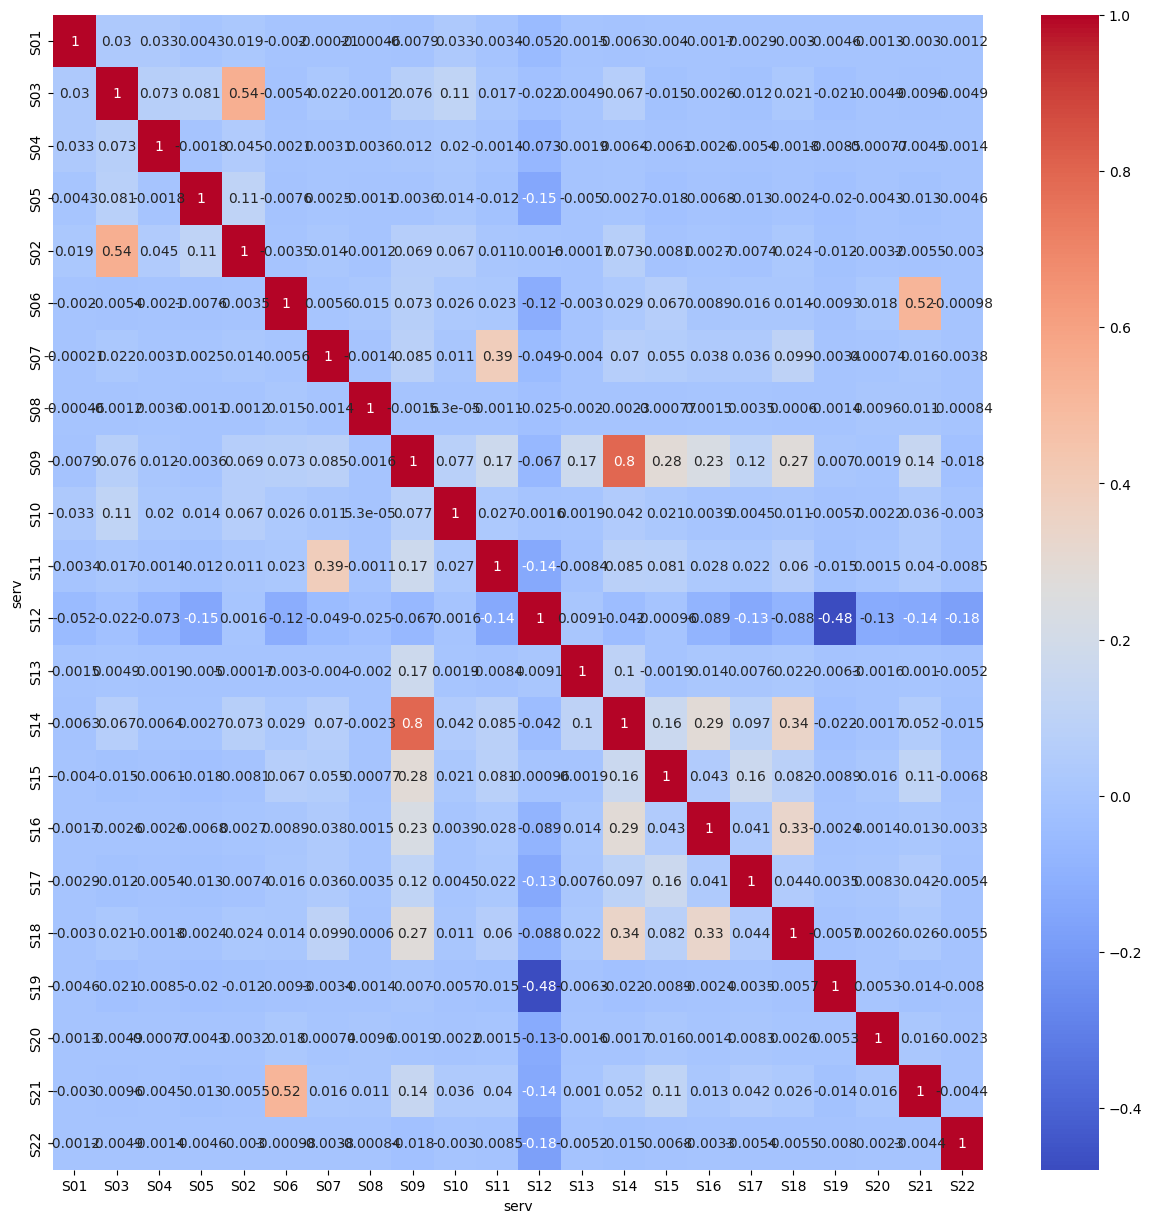

In [26]:
plt.figure(figsize=(15,15)) 
sns.heatmap(df_serv.iloc[:,1:23].corr(),annot=True, cmap='coolwarm')

<Axes: xlabel='serv', ylabel='serv'>

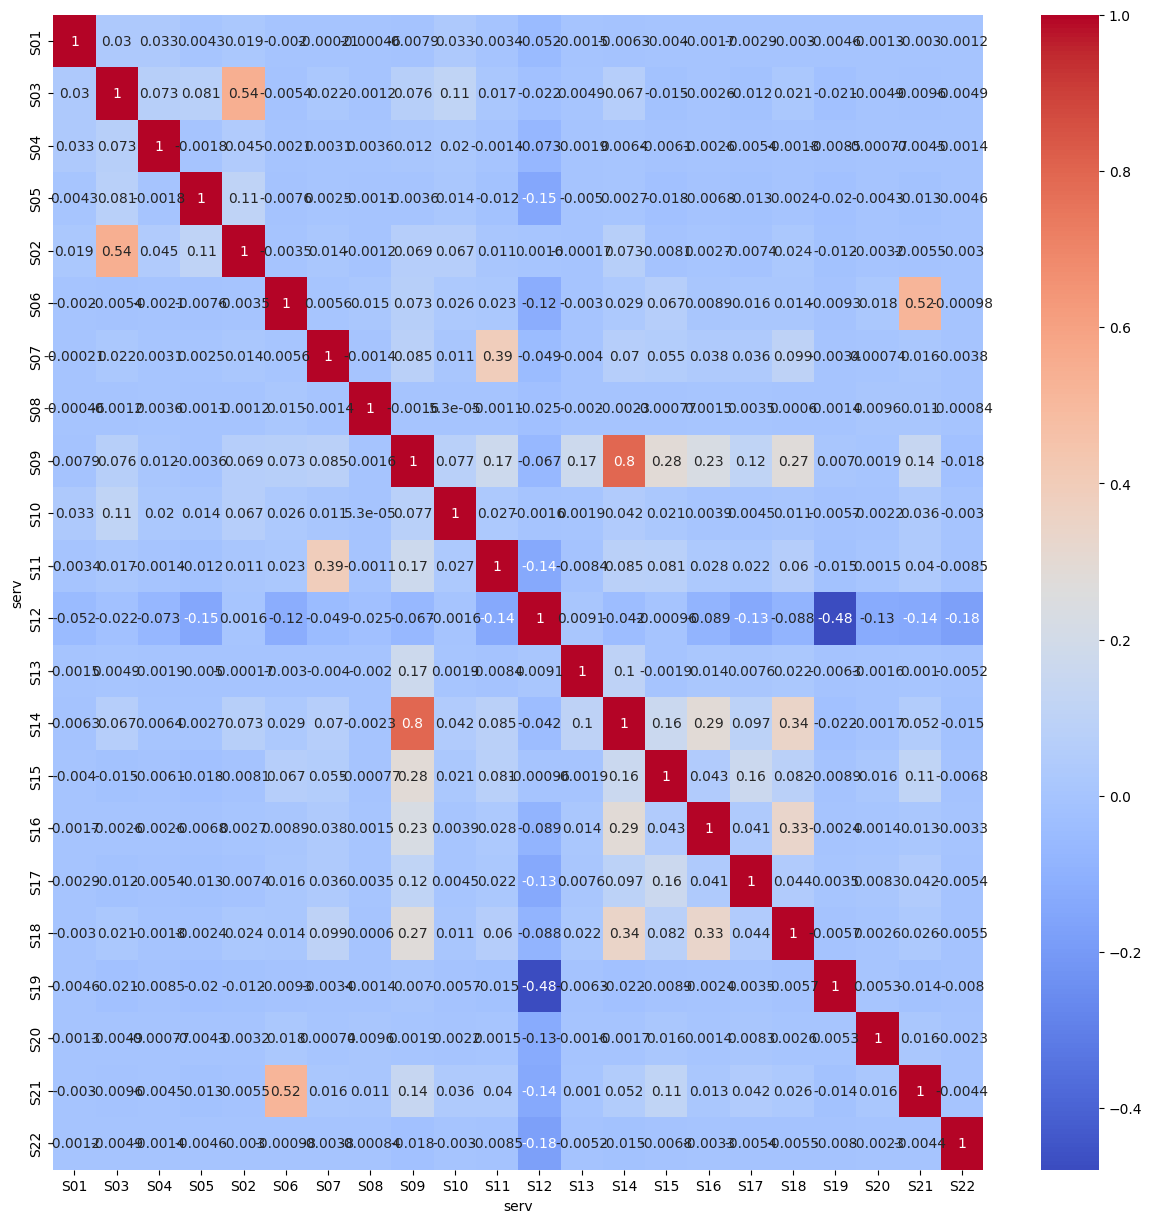

In [27]:
plt.figure(figsize=(15,15)) 
sns.heatmap(df_serv.iloc[:,1:23].corr(method="spearman"),annot=True, cmap='coolwarm')

### observations
* several "warm" spots indicating high positive correlations
* several "cold" spots indicating negative correlations, more concentrated in correlation with S12

* if we recall that there are many recipient who only uses S12, perhaps the picture may look different if we remove those recipients 


* use set operations
* recipients who used S12 only can be identified by the intersection between recipient who used S12 (ever) and those recipient who used only one service 
* we have S12_only and the rest as the total recipients subtract the S12 only recipients

In [28]:
s12_id =df.query("serv == 'S12'")['id'].unique()
one_serv_id = recipient.query("distinct_service == 1").id.to_list()
s12_only = list(set(s12_id) & set(one_serv_id))

* is this correct? how would we verify them?
* we don't have the number of recipient who does not do S12 
* the transaction data table will have groups of rows that makes up the set of services each recipient use, one row does not have S12 does not mean the recipent does not have S12


In [29]:
len(s12_id), len(one_serv_id),len(s12_only)

(502530, 424468, 401981)

* recipients who do not do "S12 only", may still do S12 along with other services

In [30]:
recipient.shape[0]-len(s12_only) # recipients who do not do "S12 only"

131818

In [31]:
df_serv[~df_serv.id.isin(s12_only)].shape # recipient not in S12_only list

(131818, 23)

* verifying through recipient who does S12 + recipient not doing S12_only is not correct
* verifying through recipient with distinct_service > 1 + receipients not doing S12 is not correct

In [32]:
df.id.nunique(), recipient.query("distinct_service > 1").id.nunique() + len(s12_only), 

(533799, 511312)

### redo correlation without the S12 only recipients

<Axes: xlabel='serv', ylabel='serv'>

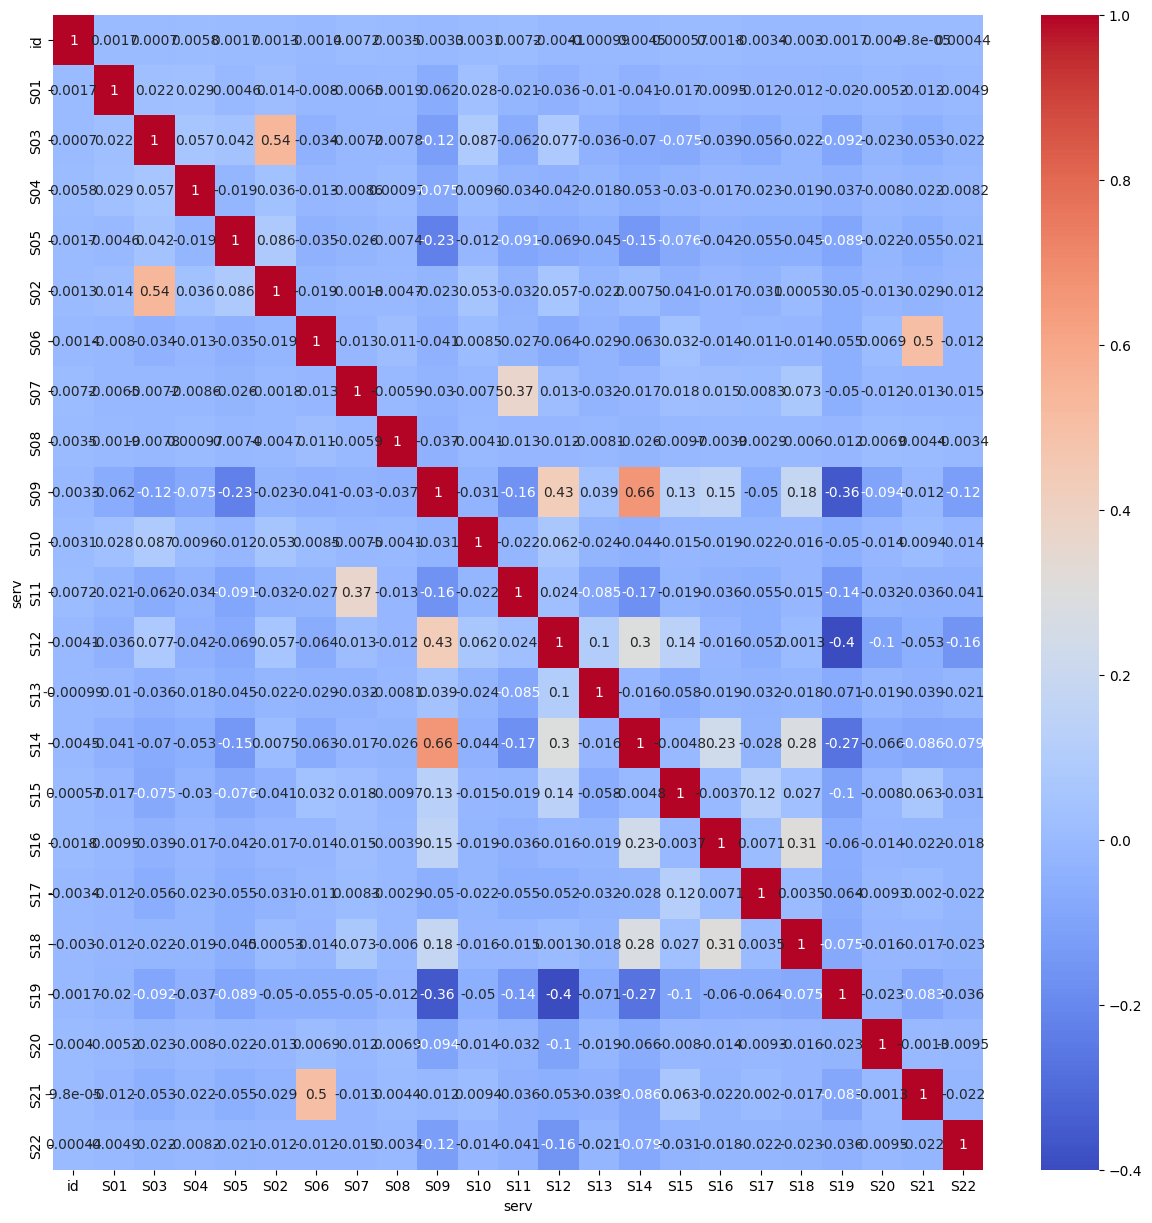

In [33]:
plt.figure(figsize=(15,15)) 
sns.heatmap(df_serv[~df_serv.id.isin(s12_only)].corr(),annot=True, cmap='coolwarm')

* we continue to see S12 has strong negative correlation with S19 (Older_Adults_Receiving_Services)
* S19 also has servel other strong negative correlations with several other services
* but we can see some positive correlations with other services

### defining behavior cohorts

* those recipients who are in some age range and received services in the earlier part of the year
* and, cohort 1 as those who have income service (S12) in addition to other services
* and, cohort 2 as those who have not received other services outside income service in this earlier part of the year
* we could overlay a filter on age, where we onyl study the age range that perhaps have potential to get off income service


In [34]:
cutoff_before = '2021-06-30'
cutoff_after = '2021-09-30'
age_lower = 24
age_upper = 55
df_before = df.query("date <= @cutoff_before")
df_after = df.query("date > @cutoff_after")

recipient_before = get_recipient_attribute(df_before)
id_s12_before =df_before.query("serv == 'S12'").id.unique()
id_one_serv_before = recipient_before.query("distinct_service == 1").id.unique()
id_s12_only_before = list(set(id_s12_before) & set(id_one_serv_before))
id_non_s12_only_before = set(id_s12_before).difference(set(id_s12_only_before))

In [35]:
# if we want to apply the demographic filtering, e.g., age range, we could do below
# if we don't want to apply the demographic filtering, comment these out
id_cohort_age = df.query("age > @age_lower and age <= @age_upper").id.unique()
id_s12_before = list(set(id_s12_before) & set(id_cohort_age))
id_s12_only_before = list(set(id_s12_only_before) & set(id_cohort_age))
id_non_s12_only_before = list(set(id_non_s12_only_before) & set(id_cohort_age))

* at first, I was going to use the logic of below, but it was wrong!!! the users with more than one services may include those who did not use S12 at all, and hence the numbers will be inflated.

* first_more_than_one_serv_id = recipient_before.query("distinct_service > 1").id.unique()
* first_more_than_s12 = list(set(id_s12_before) & set(first_more_than_one_serv_id))
* id_non_s12_only_before = df_before[~df_before.id.isin(id_s12_only_before)].id.unique()


In [36]:
df_before.id.nunique(), len(id_s12_before), len(id_s12_only_before)+len(id_non_s12_only_before),recipient_before.shape[0]-len(id_s12_only_before) # recipients not doing S12 only

(511641, 187034, 187034, 364583)

In [37]:
recipient.query("first_date > '2021-06-30'").id.count()

22158

In [38]:
recipient.shape[0]-df_before.id.nunique()

22158

### generating cohort dataframe
* we need id, and a cohort label for the cohort that the id belongs to, "ch1" denotes the recipients who only used income service in the early part of the year, "ch2" denotes the cohort that used income service in conjunction with other services in the early part of the year

In [39]:
cohort1 = pd.DataFrame(zip(id_s12_only_before, ['ch1']*len(id_s12_only_before)),columns=['id','cohort'])
cohort2 = pd.DataFrame(zip(id_non_s12_only_before, ['ch2']*len(id_non_s12_only_before)),columns=['id','cohort'])
cohort_all=pd.concat([cohort1,cohort2],axis=0)

df_before = df_before.merge(cohort_all, on=['id'], how='inner')
df_after = df_after.merge(cohort_all, on=['id'], how='inner')


In [40]:
cohort_all.head()

id cohort
0  524288    ch1
1  262144    ch1
2       3    ch1
3       5    ch1
4  524295    ch1

In [41]:
cohort_all.groupby('cohort').id.nunique()

cohort
ch1    147058
ch2     39976
Name: id, dtype: int64

In [42]:
df_before.groupby('cohort').nunique()

id  date  service  age  gender  race  ethnicity  marital  \
cohort                                                                 
ch1     147058     6        1   31       3     7          3        7   
ch2      39976     6       16   31       3     7          3        7   

        education  month  serv  age_bin  
cohort                                   
ch1             8      6     1        4  
ch2             8      6    16        4

* everyone used S12 before the cutoff, because that was our selection criteria

In [43]:
df_before.query("serv == 'S12'").groupby(['cohort']).id.nunique()

cohort
ch1    147058
ch2     39976
Name: id, dtype: int64

* looking at S12 drop-offs after the cutoff date
* some people dropped off of the services entirely
* some people dropped off of S12

In [44]:
df_after.groupby('cohort').nunique()

id  date  service  age  gender  race  ethnicity  marital  \
cohort                                                                 
ch1     144488     3       16   31       3     7          3        7   
ch2      39880     3       16   31       3     7          3        7   

        education  month  serv  age_bin  
cohort                                   
ch1             8      3    16        4  
ch2             8      3    16        4

In [45]:
df_after.query("serv == 'S12'").groupby(['cohort']).nunique()

id  date  service  age  gender  race  ethnicity  marital  \
cohort                                                                 
ch1     144447     3        1   31       3     7          3        7   
ch2      39559     3        1   31       3     7          3        7   

        education  month  serv  age_bin  
cohort                                   
ch1             8      3     1        4  
ch2             8      3     1        4

* reduction of S12 recipients

In [46]:
(df_after.groupby('cohort').id.nunique() - df_after.query("serv == 'S12'").groupby(['cohort']).nunique('id')['id'])/df_after.groupby('cohort').id.nunique()


cohort
ch1    0.000284
ch2    0.008049
Name: id, dtype: float64

In [47]:
df_before.groupby(['cohort']).nunique()['id'], df_after.query("serv == 'S12'").groupby(['cohort']).nunique()['id']

(cohort
 ch1    147058
 ch2     39976
 Name: id, dtype: int64,
 cohort
 ch1    144447
 ch2     39559
 Name: id, dtype: int64)

* or percentage of remaining on S12

In [48]:
df_after.query("serv == 'S12'").groupby(['cohort']).nunique()['id']/df_before.groupby(['cohort']).nunique()['id']


cohort
ch1    0.982245
ch2    0.989569
Name: id, dtype: float64

In [49]:
df_after.query("serv == 'S12'").groupby(['cohort']).nunique('id')['id']/df_after.groupby('cohort').id.nunique()


cohort
ch1    0.999716
ch2    0.991951
Name: id, dtype: float64

In [50]:
recipient_after = get_recipient_attribute(df_after)
recipient_after.head()

id  num_service  distinct_service first_date  last_date  num_month  \
0    3            3                 1 2021-10-31 2021-12-31          3   
3    5            3                 1 2021-10-31 2021-12-31          3   
6    9            3                 1 2021-10-31 2021-12-31          3   
9   14            3                 1 2021-10-31 2021-12-31          3   
12  15            3                 1 2021-10-31 2021-12-31          3   

    distinct_month  age    gender                      race  \
0                3   29  2~Female                   1~White   
3                3   40    1~Male  2~Black/African American   
6                3   39    1~Male                   1~White   
9                3   41    1~Male                   1~White   
12               3   39    1~Male                   1~White   

                ethnicity           marital                      education  \
0   2~Not Hispanic/Latinx         2~Married  9-12~High School (grade 9-12)   
3   2~Not Hispanic/Latinx         2~Married         UNDERGRAD~Some College   
6       1~Hispanic/Latinx  6~In Civil Union                     99~Unknown   
9              99~Unknown         4~Widowed                     99~Unknown   
12  2~Not Hispanic/Latinx         2~Married                     99~Unknown   

   serv age_bin cohort  
0   S12   20-29    ch1  
3   S12   40-49    ch1  
6   S12   30-39    ch1  
9   S12   40-49    ch1  
12  S12   30-39    ch1

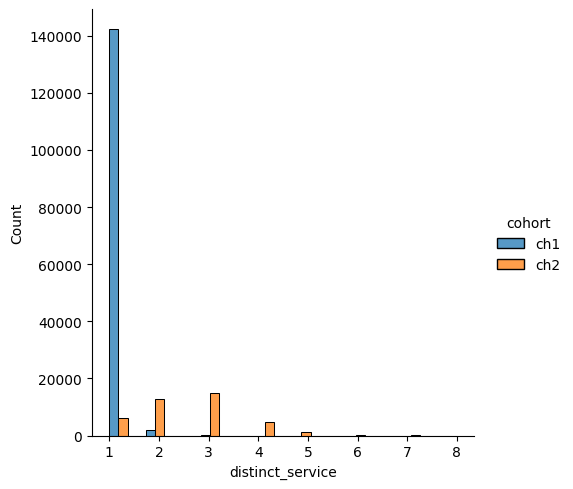

In [51]:
sns.displot(recipient_after, x="distinct_service", hue = "cohort", multiple="dodge")


In [52]:
from ydata_profiling import ProfileReport

profile = ProfileReport(recipient, title="Profiling Report")


In [53]:
profile.to_widgets()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [54]:
profile.to_notebook_iframe()


Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### In class exercises
- build you own module of helper functions, store in file, and import into your main notebook for use
- Think about the behavior cohorts
    - can we conclude that income services combined with other services helps recipients reduce their reliance on income support overtime?
    - does the conclusion make sense? i.e., can the conclusions be reasonably explained by cross validation with other data view? 
- check out pandas.crosstab https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html#pandas.crosstab , see if you can prodce a table with service as row and race and gender as columns 
 